# Useful visualizations
The default nucscenes_tutorial seems to provide a relatively comprehensive view of the different sensors and a way to view each of the different sensors in different ways. However they do not seem to show
1) Missing some views with multiple data sources. They do have camera + (lidar/) and annotaions + (camera/radar/lidar), so we could do Camera + annotations + lidar/radar. But there is also a chance that this is just too much data to visualize.  
2) Data over time. They show a video of camera + annotations, and how to layer a few sweeps of lidar, but this is it. Being able to build maps of Lidar over many sweeps could be a useful tool, or being able to visualize other object's speeds. Also just showing car movement over time.


I spent a decent amount of time trying to figure out the database and the quirks of it. These are the results of my experiments

In [14]:
# %matplotlib inline

DATADIR = "./v1.0-mini/"
VERSION = "v1.0-mini"

from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version=VERSION, dataroot=DATADIR, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.632 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [15]:
example_scene = nusc.scene[0]
example_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [16]:
example_scene = nusc.scene[0]

example_sample = nusc.get('sample', example_scene['first_sample_token'])


In [17]:
data = nusc.get('sample_data', example_sample['data']['LIDAR_TOP'])
# nusc.render_sample_data(data['token'])



In [13]:
import os, json
from PIL import Image, ImageDraw
import cv2, math
import numpy as np

def get_map_id_from_scene(scene_log_token):
    with open(os.path.join(DATADIR,VERSION,"map.json")) as f:
        maps_json = json.load(f)
    
    for map in maps_json:
        if scene_log_token in map['log_tokens']:
            return map['token']
    print("No Map Found")
    return ''

def get_map_from_token(map_token):
    return Image.open(os.path.join(DATADIR, 'maps', map_token+".png"))

def get_ego_pose(sample):
    return nusc.get("ego_pose", nusc.get('sample_data', sample['data']['LIDAR_TOP'])['ego_pose_token'])

def get_ego_poses(scene):
    current_sample = nusc.get("sample", scene['first_sample_token'])
    pos = [get_ego_pose(current_sample)]
    while current_sample['next']:
        current_sample = nusc.get("sample", current_sample['next'])
        pos.append(get_ego_pose(current_sample))
    return pos

def convert_bitmask_to_image(map):
    map = np.array(map)
    image = np.ones(list(map.shape)+[3], dtype=np.uint8)
    bitmap_array = map[:, :, np.newaxis] 
    return np.array(image * bitmap_array)

def overlay_ego_pose_on_map(poses, map_token):
    map_ = nusc.get('map', map_token)
    map_mask = map_['mask']
    # print("map size", map_mask.mask().shape)
    map = convert_bitmask_to_image(map_mask.mask())

    old_pt1 = None
    for pose in poses:
        pixel_coords = np.concatenate(map_mask.to_pixel_coords(pose['translation'][0], pose['translation'][1]))

        pt1 = np.array([pixel_coords[0], pixel_coords[1]], dtype=np.int16)
        map[pt1[1]:pt1[1]+10, pt1[0]:pt1[0]+10] = np.array([[(0,0,255) for x in range(10)] for y in range(10)])

        if old_pt1 is not None:
            map = cv2.line(map, tuple(pt1[::-1]), tuple(old_pt1[::-1]), (0,0,255), 5)

        old_pt1 = pt1
    return np.array(map)

map_token = get_map_id_from_scene(example_scene['log_token'])

map = get_map_from_token(map_token)
map = convert_bitmask_to_image(map)

poses = get_ego_poses(example_scene)
# poses
# print("Overlaying")
new_map = overlay_ego_pose_on_map(poses, map_token)

3963 4205 8441 9204
Simply Plotting the movement of the car


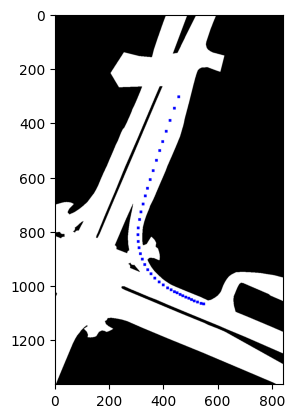

In [18]:
from  IPython import display
from matplotlib import pyplot as plt

def crop_map_to_egos(map, ego_poses, map_token,  padding = 100):
    min_x = np.inf
    min_y = np.inf
    max_x = 0
    max_y = 0
    map_ = nusc.get('map', map_token)
    map_mask = map_['mask']
    for pose in ego_poses:
        pixel_coords = np.concatenate(map_mask.to_pixel_coords(pose['translation'][0], pose['translation'][1]))
        min_x = min(min_x, pixel_coords[0])
        max_x = max(max_x, pixel_coords[0])
        min_y = min(min_y, pixel_coords[1])
        max_y = max(max_y, pixel_coords[1])
    
    print(min_x, max_x, min_y, max_y)
    return map[int(min_y) - padding : int(max_y) + padding, int(min_x) - padding: int(max_x) + padding, :]

cropped_new_map = crop_map_to_egos(new_map, poses, map_token, padding = 300)

print("Simply Plotting the movement of the car")
plt.imshow(cropped_new_map)
plt.show()


In [19]:
from nuscenes.utils.data_classes import LidarPointCloud
from scipy.spatial.transform import Rotation as R


def get_lidar_data(sample):
    path = os.path.join(DATADIR, nusc.get('sample_data', sample['data']['LIDAR_TOP'])['filename'])
    return LidarPointCloud.from_file(path).points

def get_lidar_scans(scene):
    current_sample = nusc.get("sample", scene['first_sample_token'])
    # print(current_sample)
    lidar_points = [get_lidar_data(current_sample)]
    center_points = [get_ego_pose(current_sample)]
    while current_sample['next']:
        current_sample = nusc.get("sample", current_sample['next'])
        lidar_points.append(get_lidar_data(current_sample))
        # print(lidar_points[-1].shape)
        # print(np.array(lidar_points).shape)
        center_points.append(get_ego_pose(current_sample))
    return lidar_points, center_points

def overlay_lidar_on_map(point_clouds, center_points, map_token, map=None, alpha = 20):
    map_ = nusc.get('map', map_token)
    map_mask = map_['mask']
    # print(map_mask.mask().shape)
    if map is None:
        map = convert_bitmask_to_image(map_mask.mask())

    for i in range(len(point_clouds)):
        pixel_coords = [center_points[i]['translation'][0], center_points[i]['translation'][1]]

        pt1 = np.array([pixel_coords[0], pixel_coords[1]]) 

        r = R.from_quat(center_points[i]['rotation'])

        yaw, pitch, roll = r.as_euler('zyx', degrees=False)
        angle = roll - np.pi/2

        for x, y, z,intensity in np.transpose(point_clouds[i]):
            if intensity<17  or z < -1.7: # some light filtering to remove road circles
                continue
            pt2 = [x*math.cos(angle)+y*math.sin(angle), y*math.cos(angle)-x*math.sin(angle)]

            px = np.concatenate(map_mask.to_pixel_coords(pt1[0] + pt2[0], pt1[1]+pt2[1]), dtype=np.int16)
            
            # if np.array_equal(map[px[1], px[0]], (255, 255, 255)):
            #     map[px[1], px[0]] = (0, 0, 0)

            if map[px[1], px[0], 2] != 255:
                map[px[1], px[0]] = (0, 0, min(map[px[1], px[0], 2]+alpha, 255))
            else:
                map[px[1], px[0]] = (max(map[px[1], px[0], 0]-alpha, 0), max(map[px[1], px[0], 1]-alpha, 0), 255)


        pixel_coords = np.concatenate(map_mask.to_pixel_coords(center_points[i]['translation'][0], center_points[i]['translation'][1]))
        pt1 = np.array([pixel_coords[0], pixel_coords[1]], dtype=np.int16)
        map[pt1[1]:pt1[1]+10, pt1[0]:pt1[0]+10] = np.array([[(255,0,0) for x in range(10)] for y in range(10)])

        # px = np.concatenate(map_mask.to_pixel_coords(pt1[0], pt1[1]))
        # map[int(px[1]):int(px[1])+10, int(px[0]):int(px[0])+10] = np.array([[(255,0,0) for x in range(10)] for y in range()])


    return np.array(map)

point_clouds, center_points = get_lidar_scans(example_scene)
# print(point_clouds)
# print(len(point_clouds), len(center_points[0]))
lidar_map = overlay_lidar_on_map(point_clouds, center_points, map_token)
# plt.imshow()

C:\Users\benna\AppData\Local\Temp\ipykernel_3424\4184350599.py:52: RuntimeWarning: overflow encountered in scalar subtract
  map[px[1], px[0]] = (max(map[px[1], px[0], 0]-alpha, 0), max(map[px[1], px[0], 1]-alpha, 0), 255)
C:\Users\benna\AppData\Local\Temp\ipykernel_3424\4184350599.py:50: RuntimeWarning: overflow encountered in scalar add
  map[px[1], px[0]] = (0, 0, min(map[px[1], px[0], 2]+alpha, 255))


3963 4205 8441 9204


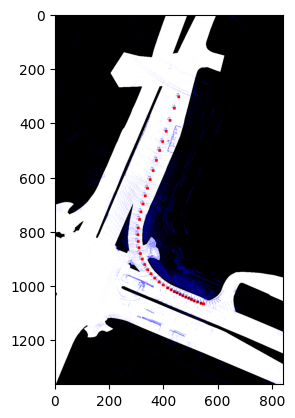

True

In [20]:
cropped = crop_map_to_egos(lidar_map, center_points, map_token, 300)

plt.imshow(cropped)
plt.show()
cv2.imwrite("lidar.png", cropped[:,:,::-1]) # for higher res
# cv2.waitKey(0)

In [21]:
#Script that i got to draw rectangles since my cv2 drawing is refusing to cooperate
def draw_rotated_rectangle(image, center_x, center_y, width, height, angle_rad, color, outline_thickness=None):
    """
    Draws a filled or outlined, rotated rectangle on a NumPy array using vectorized operations.
    Note: This function modifies the input image array in-place.

    Args:
        image (np.ndarray): The image array to draw on. It will be modified in-place.
        center_x (int): The x-coordinate of the rectangle's center.
        center_y (int): The y-coordinate of the rectangle's center.
        width (int): The width of the rectangle.
        height (int): The height of the rectangle.
        angle_rad (float): The rotation angle in radians.
        color (tuple or list): The color of the rectangle (e.g., (255, 0, 0) for red).
        outline_thickness (int, optional): The thickness of the outline. 
                                           If None, a filled rectangle is drawn. Defaults to None.

    Returns:
        np.ndarray: The modified image array.
    """
    # This function now modifies the image in-place, so no copy is created.
    
    # Pre-calculate sine and cosine of the angle for rotation
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    
    # Half width and half height for easier calculations
    half_w = width / 2
    half_h = height / 2
    
    # --- Find the bounding box of the rotated rectangle ---
    corners = []
    for i in [-1, 1]:
        for j in [-1, 1]:
            x = i * half_w
            y = j * half_h
            x_rot = x * cos_a - y * sin_a
            y_rot = x * sin_a + y * cos_a
            corners.append((center_x + x_rot, center_y + y_rot))

    min_x = int(min(c[0] for c in corners))
    max_x = int(max(c[0] for c in corners))
    min_y = int(min(c[1] for c in corners))
    max_y = int(max(c[1] for c in corners))

    # Get image dimensions for boundary checks
    img_height, img_width = image.shape[:2]

    # Clip bounding box to image dimensions
    clipped_min_x = max(0, min_x)
    clipped_max_x = min(img_width, max_x)
    clipped_min_y = max(0, min_y)
    clipped_max_y = min(img_height, max_y)

    # --- Create a grid of coordinates for the bounding box ---
    # Handle the case where the bounding box is empty after clipping
    if clipped_min_y >= clipped_max_y or clipped_min_x >= clipped_max_x:
        return image
        
    y_coords, x_coords = np.mgrid[clipped_min_y:clipped_max_y, clipped_min_x:clipped_max_x]

    # --- Perform inverse transformation on the entire grid ---
    # 1. Translate coordinates back to the origin
    tx = x_coords - center_x
    ty = y_coords - center_y
    
    # 2. Rotate the coordinates by the negative angle
    rotated_x = tx * cos_a + ty * sin_a
    rotated_y = -tx * sin_a + ty * cos_a
    
    # --- Create a boolean mask for pixels inside the rectangle ---
    mask = (np.abs(rotated_x) <= half_w) & (np.abs(rotated_y) <= half_h)
    
    # If outline_thickness is specified, adjust the mask to be an outline
    if outline_thickness is not None and outline_thickness > 0:
        # Create a mask for the inner "hole" of the rectangle
        inner_mask = (np.abs(rotated_x) < half_w - outline_thickness) & \
                     (np.abs(rotated_y) < half_h - outline_thickness)
        # The final mask is the outer rectangle area minus the inner hole
        mask = mask & ~inner_mask

    # --- Apply the color to the image using the mask ---
    # The mask is applied directly to the input image
    image[clipped_min_y:clipped_max_y, clipped_min_x:clipped_max_x][mask] = color
                
    return image

3963 4205 8441 9204
Annotations start as yellow and go to green (shows movement over the scene)


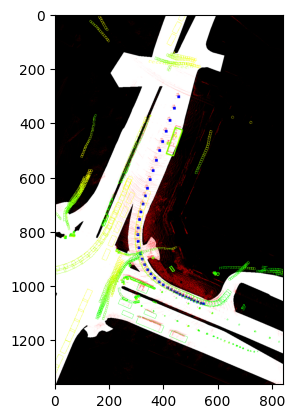

True

In [22]:
#overlaying annotations over lidar map

def get_annotataions(sample):
    return [nusc.get("sample_annotation", ann) for ann in sample['anns']]
    
from tqdm import tqdm

def overlay_annotations_on_map(scene, map = None):
    map_ = nusc.get('map', map_token)
    map_mask = map_['mask']
    # print(map_mask.mask().shape)
    if map is None:
        map = convert_bitmask_to_image(map_mask.mask())

    current_sample = nusc.get("sample", scene['first_sample_token'])
    # print(current_sample)
    anns = get_annotataions(current_sample)
    while current_sample['next']:
        current_sample = nusc.get("sample", current_sample['next'])
        anns.extend(get_annotataions(current_sample))

    map = cv2.cvtColor(np.array(Image.fromarray(map)).copy(), cv2.COLOR_RGB2BGR)
    for i, ann in enumerate(anns):
        start = [ann['translation'][0], ann['translation'][1]]
        size = [ann['size'][0], ann['size'][1]]
        
        start_px = np.concatenate(map_mask.to_pixel_coords(*start), dtype=np.int64)
        size_px = np.concatenate(map_mask.to_pixel_coords(start[0] + size[0], start[1]+size[1]), dtype=np.int64)
        size_px = [abs(size_px[0]-start_px[0]), abs(size_px[1]-start_px[1])]

        r = R.from_quat(ann['rotation'])
        yaw, pitch, roll = r.as_euler('zyx', degrees=False)
        angle = roll - np.pi/2

        # map[start_px[1]:abs(end_px[1]-start_px[1])+start_px[1], start_px[0]:abs(end_px[0]-start_px[0])+start_px[0], :] = [[(255,255,0) for x in range(abs(end_px[0]-start_px[0]))] for y in range(abs(end_px[1]-start_px[1]))]
        map = draw_rotated_rectangle(map, *start_px, *size_px, angle, (255-int(i*255/len(anns)), 255, 0), 1) # type: ignore
        # map = cv2.rectangle(map, start_px[::-1], end_px[::-1], (255, 255, 0), 3) #I have no clue why cv2 is refusing to draw


    return np.array(map)
    

ann_lidar_map = overlay_annotations_on_map(example_scene, lidar_map)
cropped = crop_map_to_egos(ann_lidar_map, center_points, map_token, 300)

print("Annotations start as yellow and go to green (shows movement over the scene)")
plt.imshow(cropped)
plt.show()
cv2.imwrite("lidar_annos.png", cropped[:,:,::-1]) # for higher res

